# Previsão de preços com vizinhança

## Neste projeto, criaremos e utilizaremos a variável 'neighborhood' para prever os preços.

In [ ]:
!pip install category_encoders --quiet

### Importação de bibliotecas

In [2]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

### Preparando os dados

Importando os dados

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

No projeto anterior, usamos nossa função Wrangle para importar dois arquivos CSV como DataFrames. Mas e se tivéssemos centenas de arquivos CSV para importar? Colocá-los em Wrangle um por um não seria uma opção. Então, vamos começar com uma técnica para ler vários arquivos CSV em um único DataFrame.

O primeiro passo é reunir os nomes de todos os arquivos que queremos importar. Podemos fazer isso usando correspondência de padrões.

In [4]:
files = glob("/content/buenos-aires-real-estate-*.csv")
files

['/content/buenos-aires-real-estate-4.csv',
 '/content/buenos-aires-real-estate-2.csv',
 '/content/buenos-aires-real-estate-5.csv',
 '/content/buenos-aires-real-estate-1.csv',
 '/content/buenos-aires-real-estate-3.csv']

O próximo passo é ler cada um dos CSVs nos arquivos para um DataFrame e colocar todos esses DataFrames em uma lista.

In [5]:
frames = [wrangle(file) for file in files]
print("Total de data frames: ", len(frames))
for frame in frames:
    print(frame.shape)

Total de data frames:  5
(1305, 17)
(1315, 17)
(1331, 17)
(1343, 17)
(1288, 17)


O passo final é usar o pandas para combinar todos os DataFrames em frames.

In [6]:
df = pd.concat(frames, ignore_index=True)
print(df.shape)
df.head()

(6582, 17)


,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,59000.0,USD,894581.60,59000.0,0.0,40.0,NaN,1475.000000,NaN,2.0,NaN,http://paternal.properati.com.ar/12t3j_venta_d...,-34.604069,-58.460209,Paternal
1,sell,apartment,78900.0,USD,1196313.36,78900.0,43.0,38.0,1834.883721,2076.315789,1.0,1.0,1600.0,http://congreso.properati.com.ar/12j7y_venta_d...,-34.620026,-58.388467,Congreso
2,sell,apartment,240000.0,USD,3638976.00,240000.0,97.0,88.0,2474.226804,2727.272727,NaN,4.0,NaN,http://agronomia.properati.com.ar/10vec_venta_...,-34.599857,-58.489002,Agronomía
3,sell,apartment,75000.0,USD,1137180.00,75000.0,NaN,34.0,NaN,2205.882353,4.0,2.0,NaN,http://balvanera.properati.com.ar/10vnl_venta_...,-34.612338,-58.401328,Balvanera
4,sell,apartment,110000.0,USD,1667864.00,110000.0,NaN,46.0,NaN,2391.304348,2.0,2.0,NaN,http://parque-chas.properati.com.ar/yc23_venta...,-34.586160,-58.475633,Parque Chas


### Explore

Observando a saída da chamada df.head() acima, vemos que precisamos fazer uma pequena limpeza antes de podermos trabalhar com as informações de vizinhança neste conjunto de dados. A boa notícia é que, como estamos usando uma função Wrangle, precisamos apenas alterá-la para limpar novamente todos os nossos arquivos CSV. É por isso que as funções são tão úteis.

Modifiquei a função Wrangle para criar um novo recurso "neighborhood". Essa informação pode ser encontrada a vizinhança de cada propriedade na coluna "place_with_parent_names". Por exemplo, uma propriedade com o nome de lugar "|Argentina|Capital Federal|Palermo|" está localizada na vizinhança "Palermo". Além disso, atualizei a função para remover a coluna "place_with_parent_names".

### Split

In [7]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

### Build Model

Baseline

In [8]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


### Iterate

In [9]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Paternal,neighborhood_Congreso,neighborhood_Agronomía,neighborhood_Balvanera,neighborhood_Parque Chas,neighborhood_Villa Pueyrredón,neighborhood_Palermo,neighborhood_Boedo,neighborhood_Caballito,neighborhood_Coghlan,...,neighborhood_Las Cañitas,neighborhood_San Nicolás,neighborhood_Mataderos,neighborhood_Villa Lugano,neighborhood_Versalles,neighborhood_Villa Ortuzar,neighborhood_Pompeya,neighborhood_Parque Avellaneda,neighborhood_Catalinas,neighborhood_Tribunales
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

### Evaluate

In [11]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39339.72


### Comunicando os resultados

Se escrevermos a equação do nosso modelo, ela ficará grande demais para caber na tela. Isso porque, quando usamos o OneHotEncoder para codificar os dados de vizinhança, criamos um DataFrame muito mais amplo, e cada coluna/característica tem seu próprio coeficiente na equação do nosso modelo.

"Equation: y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60 "

É importante ter isso em mente por dois motivos. Primeiro, significa que este é um modelo de **alta dimensão**. Em vez de um gráfico 2D ou 3D, precisaríamos de um gráfico de 58 dimensões para representá-lo, o que é impossível! Segundo, significa que precisaremos extrair e representar as informações da nossa equação de uma forma um pouco diferente do que antes. Vamos começar obtendo nosso intercepto e coeficiente.

In [14]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[ -6178.1583097   -7000.99027112    246.33072328 -10169.80004923
 -33704.37424566]


Temos os valores dos nossos coeficientes, mas como sabemos a quais características eles pertencem? Precisamos obter essa informação acessando a parte do nosso pipeline que realizou a codificação.

In [15]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Paternal' 'neighborhood_Congreso' 'neighborhood_Agronomía'
 'neighborhood_Balvanera' 'neighborhood_Parque Chas']


Temos coeficientes e nomes de características, e agora precisamos juntá-los. Para isso, usaremos uma série.

In [16]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

,0
neighborhood_Paternal,-6178.158310
neighborhood_Congreso,-7000.990271
neighborhood_Agronomía,246.330723
neighborhood_Balvanera,-10169.800049
neighborhood_Parque Chas,-33704.374246


Para deixar claro, definitivamente não é uma boa ideia mostrar esta equação longa para uma plateia, mas vamos imprimi-la só para conferir nosso trabalho. Como há tantos termos para imprimir, usaremos um laço for.

In [17]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 117472.02
+ (-6178.16 * neighborhood_Paternal)
+ (-7000.99 * neighborhood_Congreso)
+ (246.33 * neighborhood_Agronomía)
+ (-10169.8 * neighborhood_Balvanera)
+ (-33704.37 * neighborhood_Parque Chas)
+ (-7193.53 * neighborhood_Villa Pueyrredón)
+ (47056.22 * neighborhood_Palermo)
+ (-5846.93 * neighborhood_Boedo)
+ (10324.25 * neighborhood_Caballito)
+ (13502.09 * neighborhood_Coghlan)
+ (56930.11 * neighborhood_Barrio Norte)
+ (48091.9 * neighborhood_Belgrano)
+ (-3599.99 * neighborhood_Barracas)
+ (7345.22 * neighborhood_Villa Crespo)
+ (15837.8 * neighborhood_Saavedra)
+ (-6993.83 * neighborhood_Centro / Microcentro)
+ (-6796.62 * neighborhood_Parque Chacabuco)
+ (-2217.14 * neighborhood_Once)
+ (-1910.75 * neighborhood_Chacarita)
+ (3964.48 * neighborhood_Almagro)
+ (-11670.1 * neighborhood_Villa del Parque)
+ (44058.06 * neighborhood_Nuñez)
+ (13757.87 * neighborhood_Villa Urquiza)
+ (6723.69 * neighborhood_San Telmo)
+ (4957.08 * neighborhood_Villa Devoto)
+ (-13177.69 * n

Criando um gráfico de barras horizontais que mostra os 15 principais coeficientes para o modelo, com base em seu valor absoluto.

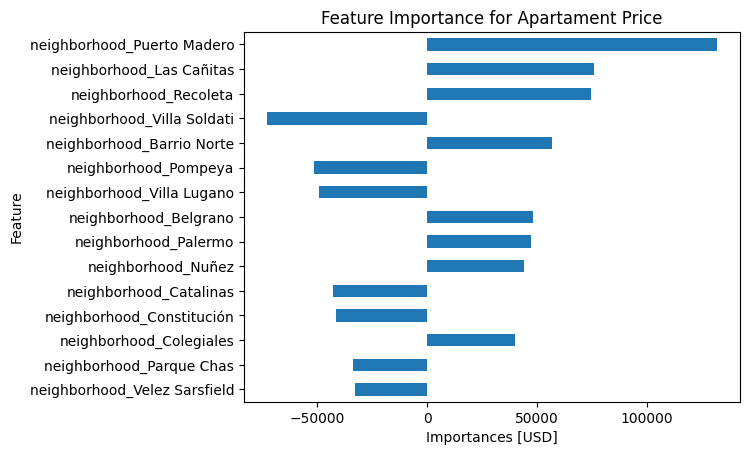

In [18]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importances [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartament Price");

### Testando com o modelo Ridge ao invés de LinearRegression

In [19]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [20]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


In [22]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[ -7108.23278979  -7974.66342534   -772.70368229 -11172.55279922
 -32439.8708326 ]


In [23]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Paternal' 'neighborhood_Congreso' 'neighborhood_Agronomía'
 'neighborhood_Balvanera' 'neighborhood_Parque Chas']


In [24]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

,0
neighborhood_Paternal,-7108.232790
neighborhood_Congreso,-7974.663425
neighborhood_Agronomía,-772.703682
neighborhood_Balvanera,-11172.552799
neighborhood_Parque Chas,-32439.870833


In [25]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-7108.23 * neighborhood_Paternal)
+ (-7974.66 * neighborhood_Congreso)
+ (-772.7 * neighborhood_Agronomía)
+ (-11172.55 * neighborhood_Balvanera)
+ (-32439.87 * neighborhood_Parque Chas)
+ (-8093.45 * neighborhood_Villa Pueyrredón)
+ (45934.41 * neighborhood_Palermo)
+ (-6837.4 * neighborhood_Boedo)
+ (9252.89 * neighborhood_Caballito)
+ (12223.11 * neighborhood_Coghlan)
+ (55590.93 * neighborhood_Barrio Norte)
+ (46954.21 * neighborhood_Belgrano)
+ (-4618.66 * neighborhood_Barracas)
+ (6277.05 * neighborhood_Villa Crespo)
+ (14701.16 * neighborhood_Saavedra)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-7678.62 * neighborhood_Parque Chacabuco)
+ (-3230.37 * neighborhood_Once)
+ (-2898.96 * neighborhood_Chacarita)
+ (2903.34 * neighborhood_Almagro)
+ (-12595.5 * neighborhood_Villa del Parque)
+ (42831.32 * neighborhood_Nuñez)
+ (12671.71 * neighborhood_Villa Urquiza)
+ (5638.47 * neighborhood_San Telmo)
+ (3860.58 * neighborhood_Villa Devoto)
+ (-14088.02 * 

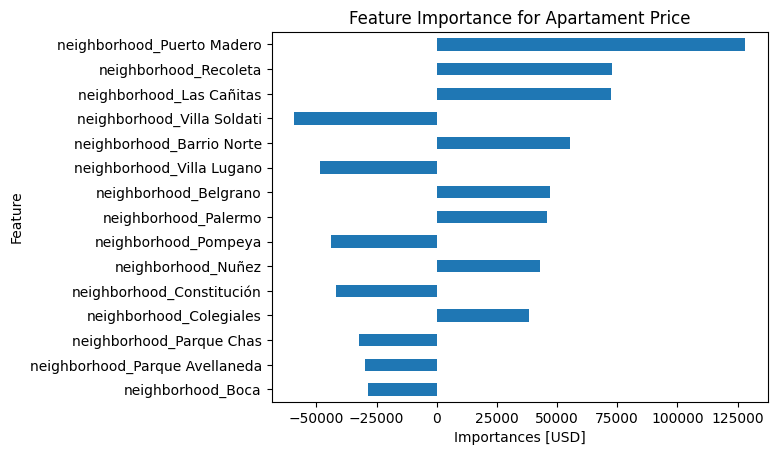

In [26]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importances [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartament Price");